In [1]:
from pymongo import MongoClient
client = MongoClient("mongodb://localhost:27017/")
db = client.crypto
collection = db.crypto_collection

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Hyperparameters

In [20]:
PRODUCT_ID = "ETH-USD"
SHOW_DATA = False

In [4]:
def make_data(collection):
    df = pd.DataFrame.from_dict(collection.find({"type":"ticker", "product_id":PRODUCT_ID}))
    df['date_time_float'] = pd.to_datetime(df.time).astype(int) / 10**9
    df.price = df.price.astype(float)
    df.open_24h = df.open_24h.astype(float)
    df.volume_24h = df.volume_24h.astype(float)
    df.low_24h = df.low_24h.astype(float)
    df.high_24h = df.high_24h.astype(float)
    df.volume_30d = df.volume_30d.astype(float)
    df.best_bid = df.best_bid.astype(float)
    df.best_ask = df.best_ask.astype(float)
    df.trade_id = df.trade_id.astype(int)
    df.time = pd.to_datetime(df.time)
    
    if SHOW_DATA:
        print(df.head())
        print(df.info())
    
    return df

In [5]:
df = make_data(collection)

In [33]:
collection.count()

247135

In [7]:
collection.count({"type":"ticker"})

29

In [8]:
ticker = collection.find_one({"type":"ticker", "product_id":PRODUCT_ID})

In [9]:
if SHOW_DATA == True:
    print(ticker)

In [10]:
if SHOW_DATA:
    print(list(ticker.keys()))

In [11]:
if SHOW_DATA == True:
    df.info()

In [12]:
if SHOW_DATA == True:
    df.describe()

In [13]:
df.product_id.value_counts()

BTC-USD    14
Name: product_id, dtype: int64

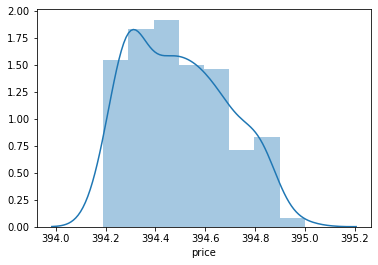

In [23]:
sns.distplot(make_data(collection).price)

In [15]:
df.time = df['time'].dt.tz_localize(None)

In [16]:
df.info()
df.to_excel('ticker_data.xlsx', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   _id              14 non-null     object        
 1   type             14 non-null     object        
 2   sequence         14 non-null     int64         
 3   product_id       14 non-null     object        
 4   price            14 non-null     float64       
 5   open_24h         14 non-null     float64       
 6   volume_24h       14 non-null     float64       
 7   low_24h          14 non-null     float64       
 8   high_24h         14 non-null     float64       
 9   volume_30d       14 non-null     float64       
 10  best_bid         14 non-null     float64       
 11  best_ask         14 non-null     float64       
 12  side             14 non-null     object        
 13  time             14 non-null     datetime64[ns]
 14  trade_id         14 non-null     int32      

Check the distribution of time among data to see if the data are evenly spread

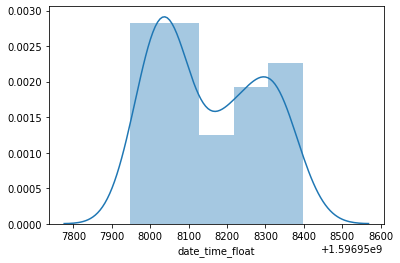

In [24]:
sns.distplot(df.date_time_float)

# Dash

## From Simple Tutorial on Dash
#### Working !!!

In [32]:
def make_fig(df):
    fig = px.scatter(df, x='time', y='price',
                    template='plotly_dark')
    fig.update_xaxes(rangeslider_visible=True) # add tick format
    
    return fig


In [22]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
from jupyter_dash import JupyterDash
import pandas as pd

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

# assume you have a "long-form" data frame
# see https://plotly.com/python/px-arguments/ for more options
df = make_data(collection)
fig = make_fig(df)

app.layout = html.Div(children=[
    html.H1(children=PRODUCT_ID + ' Trend'),

    html.Div(children='''
        Dash: A web application framework for Python.
    '''),

    dcc.Graph(
        id='live-graph',
        figure=fig
    ),
    
    dcc.Interval(
                id='interval-component',
                interval=1*1000, # in milliseconds
                n_intervals=0
            )
])

@app.callback(Output('live-graph', 'figure'),
              [Input('interval-component', 'n_intervals')])
def update_data(n):
    df = make_data(collection)
    fig = make_fig(df)
    
    return fig


app.run_server(mode='external', port=8060, debug=True)

Dash app running on http://127.0.0.1:8060/


In [31]:
# Darkk Mode

In [30]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
from jupyter_dash import JupyterDash
import pandas as pd

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

colors = {
    'background': '#111111',
    'text': '#7FDBFF'
}

# assume you have a "long-form" data frame
# see https://plotly.com/python/px-arguments/ for more options
df = make_data(collection)
fig = make_fig(df)

app.layout = html.Div(style={'backgroundColor': colors['background']}, children=[
    html.H1(style={'color': colors['text']}, children=PRODUCT_ID + ' Trend'),

    html.Div(style={'color': colors['text']}, children='''
        Dash: A web application framework for Python.
    '''),

    dcc.Graph(
        id='live-graph',
        figure=fig
    ),
    
    dcc.Interval(
                id='interval-component',
                interval=1*1000, # in milliseconds
                n_intervals=0
            )
])

@app.callback(Output('live-graph', 'figure'),
              [Input('interval-component', 'n_intervals')])
def update_data(n):
    df = make_data(collection)
    fig = make_fig(df)
    
    return fig


app.run_server(mode='external', port=8060, debug=True)

Dash app running on http://127.0.0.1:8060/
